In [1]:
# Importaciones

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from sklearn.model_selection import train_test_split
import json


import sys
sys.path.append("../")
import dotenv # type: ignore
dotenv.load_dotenv()
from src import support_bd as bd
from src import support_tsf as tsf

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
df = bd.select_datos("alumnos")
df = df[df.comprado == 1]

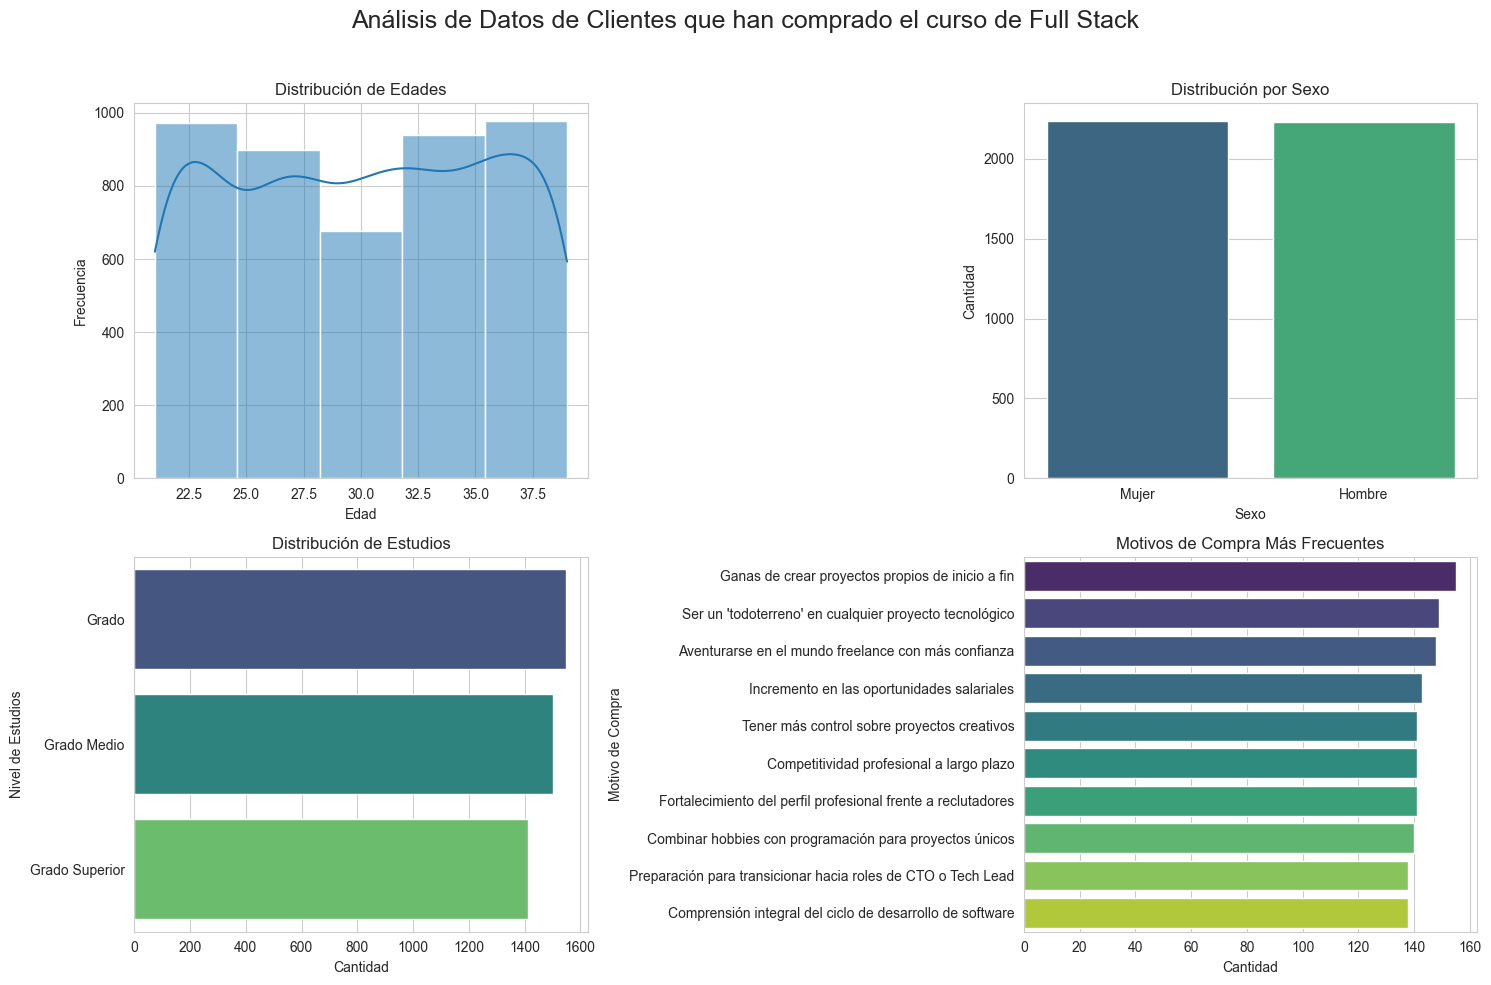

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_style("whitegrid")

# Crear figura y ejes para subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 3 filas, 2 columnas
fig.suptitle("Análisis de Datos de Clientes que han comprado el curso de Full Stack", fontsize=18)  # Título principal

# Gráfico 1: Histograma de edades
sns.histplot(df["edad"], bins=5, kde=True, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Distribución de Edades")
axes[0, 0].set_xlabel("Edad")
axes[0, 0].set_ylabel("Frecuencia")

# Gráfico 2: Conteo por sexo
sns.countplot(x="sexo", data=df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("Distribución por Sexo")
axes[0, 1].set_xlabel("Sexo")
axes[0, 1].set_ylabel("Cantidad")

# Gráfico 3: Conteo de niveles de estudio
sns.countplot(y="estudios", data=df, order=df["estudios"].value_counts().index, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title("Distribución de Estudios")
axes[1, 0].set_xlabel("Cantidad")
axes[1, 0].set_ylabel("Nivel de Estudios")

# Gráfico 5: Motivos de compra más frecuentes (Top 10)
top_motivos = df["motivo_compra"].value_counts().nlargest(10)
sns.barplot(y=top_motivos.index, x=top_motivos.values, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title("Motivos de Compra Más Frecuentes")
axes[1, 1].set_xlabel("Cantidad")
axes[1, 1].set_ylabel("Motivo de Compra")

# Ajustar diseño para evitar solapamientos
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste para dejar espacio al título
plt.show()


In [4]:
df = bd.select_datos("leads")

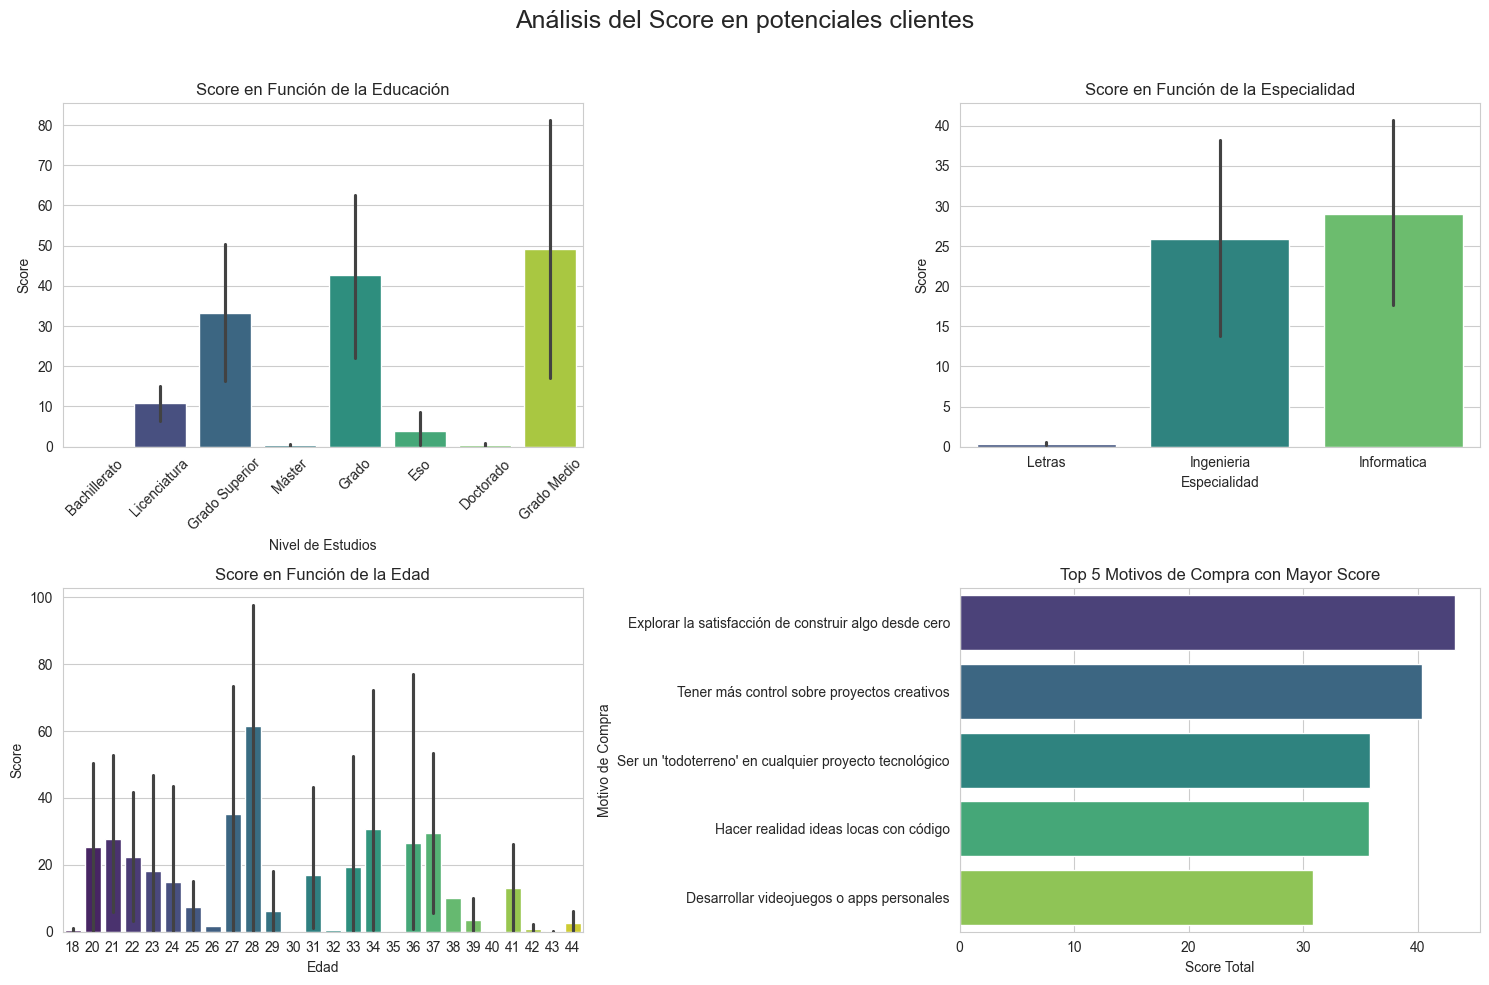

In [7]:
# Configuración de estilo
sns.set_style("whitegrid")

# Crear figura y ejes para subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 4 filas, 2 columnas
fig.suptitle("Análisis del Score en potenciales clientes", fontsize=18)  # Título principal

# Gráfico 1: Score por nivel de estudios
sns.barplot(x=df["estudios"], y=df["score"], ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Score en Función de la Educación")
axes[0, 0].set_xlabel("Nivel de Estudios")
axes[0, 0].tick_params(axis='x', rotation=45)  # 🔹 Rotar etiquetas del eje X
axes[0, 0].set_ylabel("Score")

# Gráfico 2: Score por especialidad
sns.barplot(x=df["especialidad"], y=df["score"], ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("Score en Función de la Especialidad")
axes[0, 1].set_xlabel("Especialidad")
axes[0, 1].set_ylabel("Score")

# Gráfico 4: Score en función de la edad (barplot)
sns.barplot(x=df["edad"], y=df["score"], ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title("Score en Función de la Edad")
axes[1, 0].set_xlabel("Edad")
axes[1, 0].set_ylabel("Score")

top_motivos = df.groupby("motivo_compra")["score"].median().nlargest(5)  # Agrupar por motivo y obtener top 10
sns.barplot(y=top_motivos.index, x=top_motivos.values, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title("Top 5 Motivos de Compra con Mayor Score")
axes[1, 1].set_xlabel("Score Total")
axes[1, 1].set_ylabel("Motivo de Compra")

# Gráfico 5: Histograma de edades

# Ajustar diseño para evitar solapamientos
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste para dejar espacio al título
plt.show()
